In [10]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [12]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [13]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/IncpetionResNetV2'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [14]:
# Parameters
img_height, img_width = 299, 299  # InceptionV3 requires images of size 299x299
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [15]:
# Function to create train, validation, and test splits
def create_splits():
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(dataset_dir):        
        train_class_path = os.path.join(train_dir, class_name)        
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)        
        
        test_class_path = os.path.join(test_dir, class_name)        
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)        

        validation_class_dir = os.path.join(validation_dir, class_name)       
        if not os.path.exists(validation_class_dir):
            os.makedirs(validation_class_dir)        
    
    for class_name in os.listdir(dataset_dir):        
        class_path = os.path.join(dataset_dir, class_name)
        
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)
            train_split = int(train_ratio * len(images))
            validation_split = int(validation_ratio * len(images))
            
            train_images = images[:train_split]
            validation_images = images[train_split:train_split + validation_split]
            test_images = images[train_split + validation_split:]

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
            for image in validation_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))


In [16]:
# Split the dataset
create_splits()

In [17]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1083 images belonging to 5 classes.
Found 230 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


# Architecture No 1

In [19]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-09-08 18:38:11.986608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46172 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 18:38:28.819302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-09-08 18:38:29.436143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-08 18:38:30.190529: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcf10027d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-08 18:38:30.190567: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-08 18:38:30.204718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 18:38:30.417596: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

33/33 [==============================] - ETA: 0s - loss: 1.7725 - accuracy: 0.2360

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 40s 871ms/step - loss: 1.7725 - accuracy: 0.2360 - val_loss: 1.6753 - val_accuracy: 0.2366
Epoch 2/50
33/33 [==============================] - 25s 769ms/step - loss: 1.7300 - accuracy: 0.2569 - val_loss: 1.6309 - val_accuracy: 0.2455
Epoch 3/50
33/33 [==============================] - 25s 767ms/step - loss: 1.7125 - accuracy: 0.2360 - val_loss: 1.6170 - val_accuracy: 0.2411
Epoch 4/50
33/33 [==============================] - 24s 742ms/step - loss: 1.6771 - accuracy: 0.2502 - val_loss: 1.6219 - val_accuracy: 0.2723
Epoch 5/50
33/33 [==============================] - 24s 734ms/step - loss: 1.6537 - accuracy: 0.2712 - val_loss: 1.6285 - val_accuracy: 0.2589
Epoch 6/50
33/33 [==============================] - 24s 722ms/step - loss: 1.6538 - accuracy: 0.2607 - val_loss: 1.6287 - val_accuracy: 0.2723
Epoch 7/50
33/33 [==============================] - 24s 713ms/step - loss: 1.6287 - accuracy: 0.2645 - val_loss: 1.6287 - val_accuracy: 0.2723
Epoch 8/50

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 2s 202ms/step - loss: 1.6028 - accuracy: 0.2134
Test accuracy: 0.21


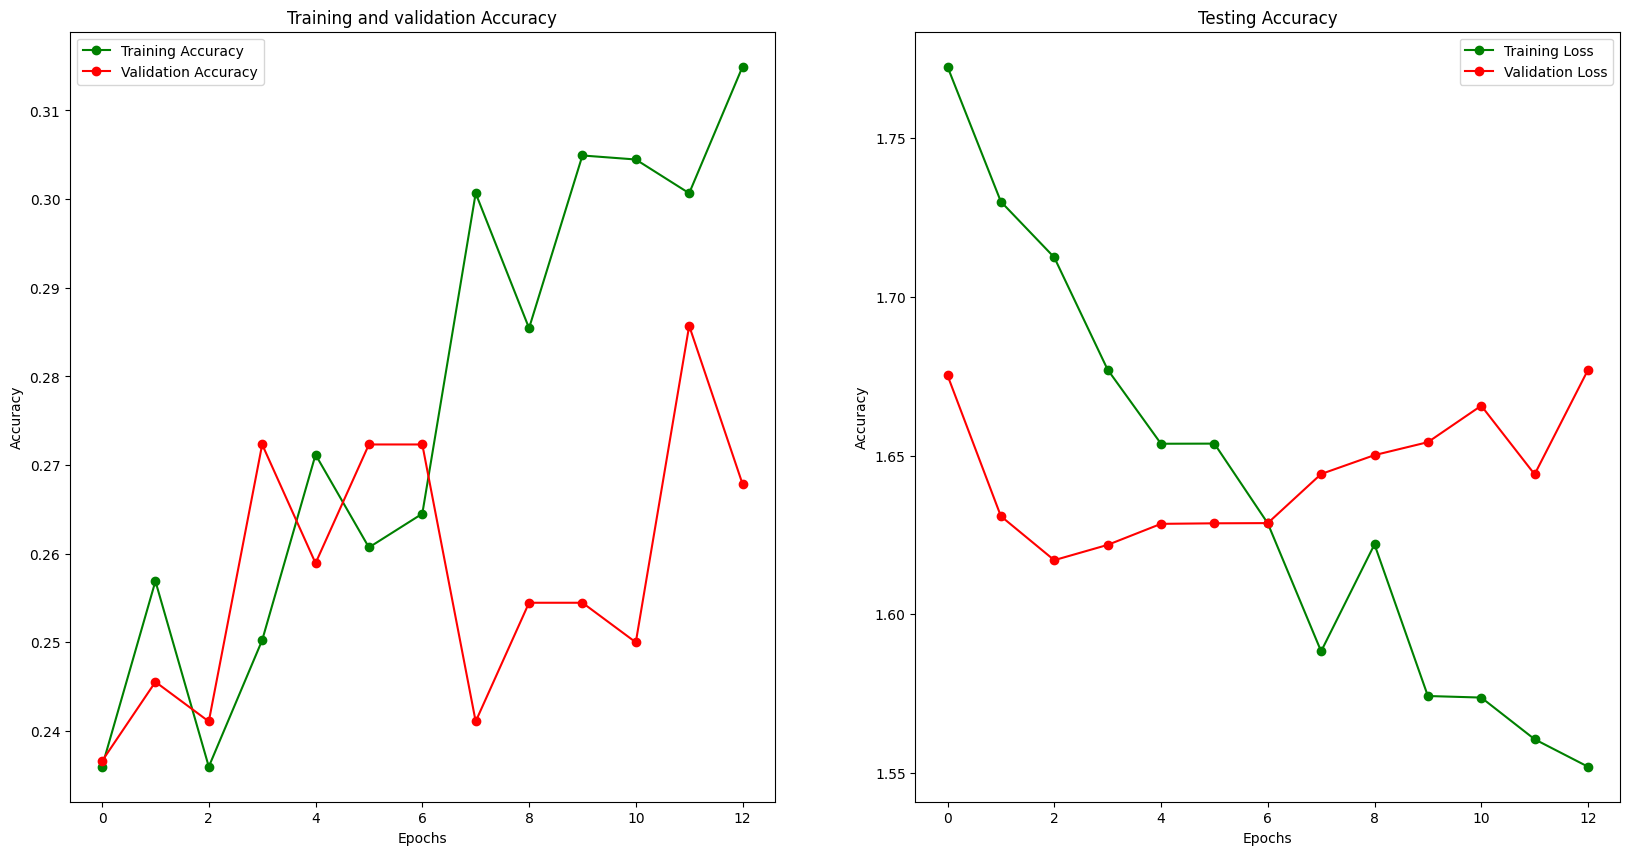

8/8 [==============================] - 4s 115ms/step


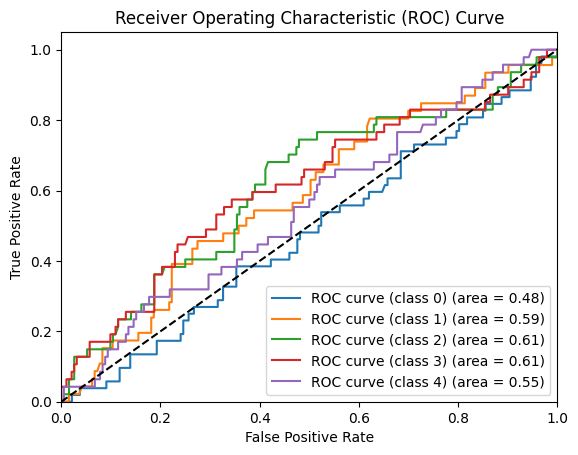

In [22]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 1 

In [23]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 2s 187ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.21
Precision: 0.25
Recall: 0.21
F1 Score: 0.19
F2 Score: 0.20


In [24]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 115ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.52


# Architecture No 2

In [25]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True
    
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.9539 - accuracy: 0.2065

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 38s 847ms/step - loss: 1.9539 - accuracy: 0.2065 - val_loss: 1.6569 - val_accuracy: 0.1920
Epoch 2/50
33/33 [==============================] - 25s 759ms/step - loss: 1.8603 - accuracy: 0.2084 - val_loss: 1.6283 - val_accuracy: 0.2098
Epoch 3/50
33/33 [==============================] - 26s 793ms/step - loss: 1.7616 - accuracy: 0.2417 - val_loss: 1.6059 - val_accuracy: 0.2545
Epoch 4/50
33/33 [==============================] - 25s 764ms/step - loss: 1.7294 - accuracy: 0.2407 - val_loss: 1.6000 - val_accuracy: 0.2589
Epoch 5/50
33/33 [==============================] - 25s 765ms/step - loss: 1.7184 - accuracy: 0.2379 - val_loss: 1.5960 - val_accuracy: 0.2545
Epoch 6/50
33/33 [==============================] - 23s 707ms/step - loss: 1.6927 - accuracy: 0.2578 - val_loss: 1.6010 - val_accuracy: 0.2589
Epoch 7/50
33/33 [==============================] - 24s 711ms/step - loss: 1.6573 - accuracy: 0.2702 - val_loss: 1.6019 - val_accuracy: 0.2679
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 114ms/step - loss: 1.6093 - accuracy: 0.2301
Test accuracy: 0.23


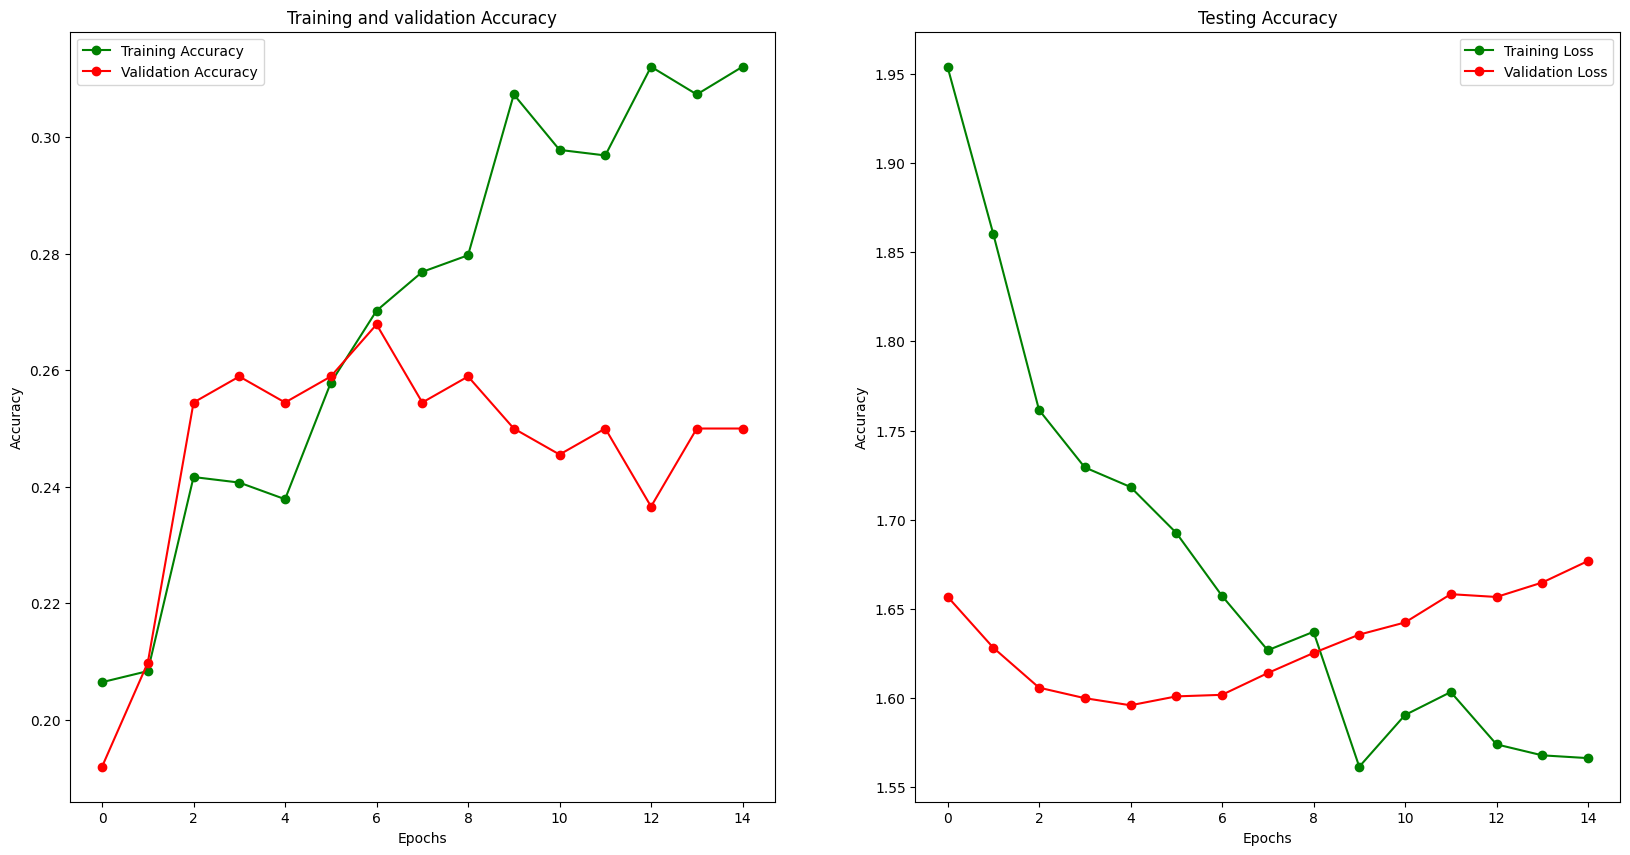

8/8 [==============================] - 4s 114ms/step


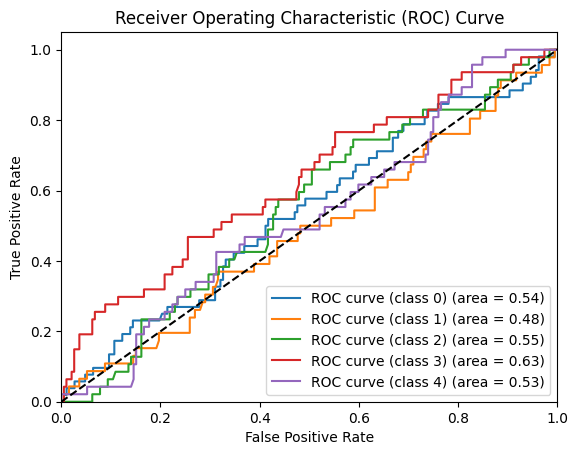

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 2

In [29]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 115ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.17
Precision: 0.14
Recall: 0.17
F1 Score: 0.15
F2 Score: 0.16
8/8 [==============================] - 1s 108ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.50


# Architecture No 4

In [30]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.2417

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 39s 816ms/step - loss: 1.8261 - accuracy: 0.2417 - val_loss: 1.6032 - val_accuracy: 0.2277
Epoch 2/50
33/33 [==============================] - 23s 707ms/step - loss: 1.6292 - accuracy: 0.3007 - val_loss: 1.6242 - val_accuracy: 0.1920
Epoch 3/50
33/33 [==============================] - 24s 709ms/step - loss: 1.5414 - accuracy: 0.3520 - val_loss: 1.6126 - val_accuracy: 0.2277
Epoch 4/50
33/33 [==============================] - 24s 718ms/step - loss: 1.5234 - accuracy: 0.3663 - val_loss: 1.6260 - val_accuracy: 0.2188
Epoch 5/50
33/33 [==============================] - 26s 775ms/step - loss: 1.4476 - accuracy: 0.3787 - val_loss: 1.6015 - val_accuracy: 0.2545
Epoch 6/50
33/33 [==============================] - 24s 722ms/step - loss: 1.4235 - accuracy: 0.3806 - val_loss: 1.6197 - val_accuracy: 0.2634
Epoch 7/50
33/33 [==============================] - 24s 712ms/step - loss: 1.4037 - accuracy: 0.4072 - val_loss: 1.6215 - val_accuracy: 0.2455
Epoch 8/50

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 108ms/step - loss: 1.5703 - accuracy: 0.2845
Test accuracy: 0.28


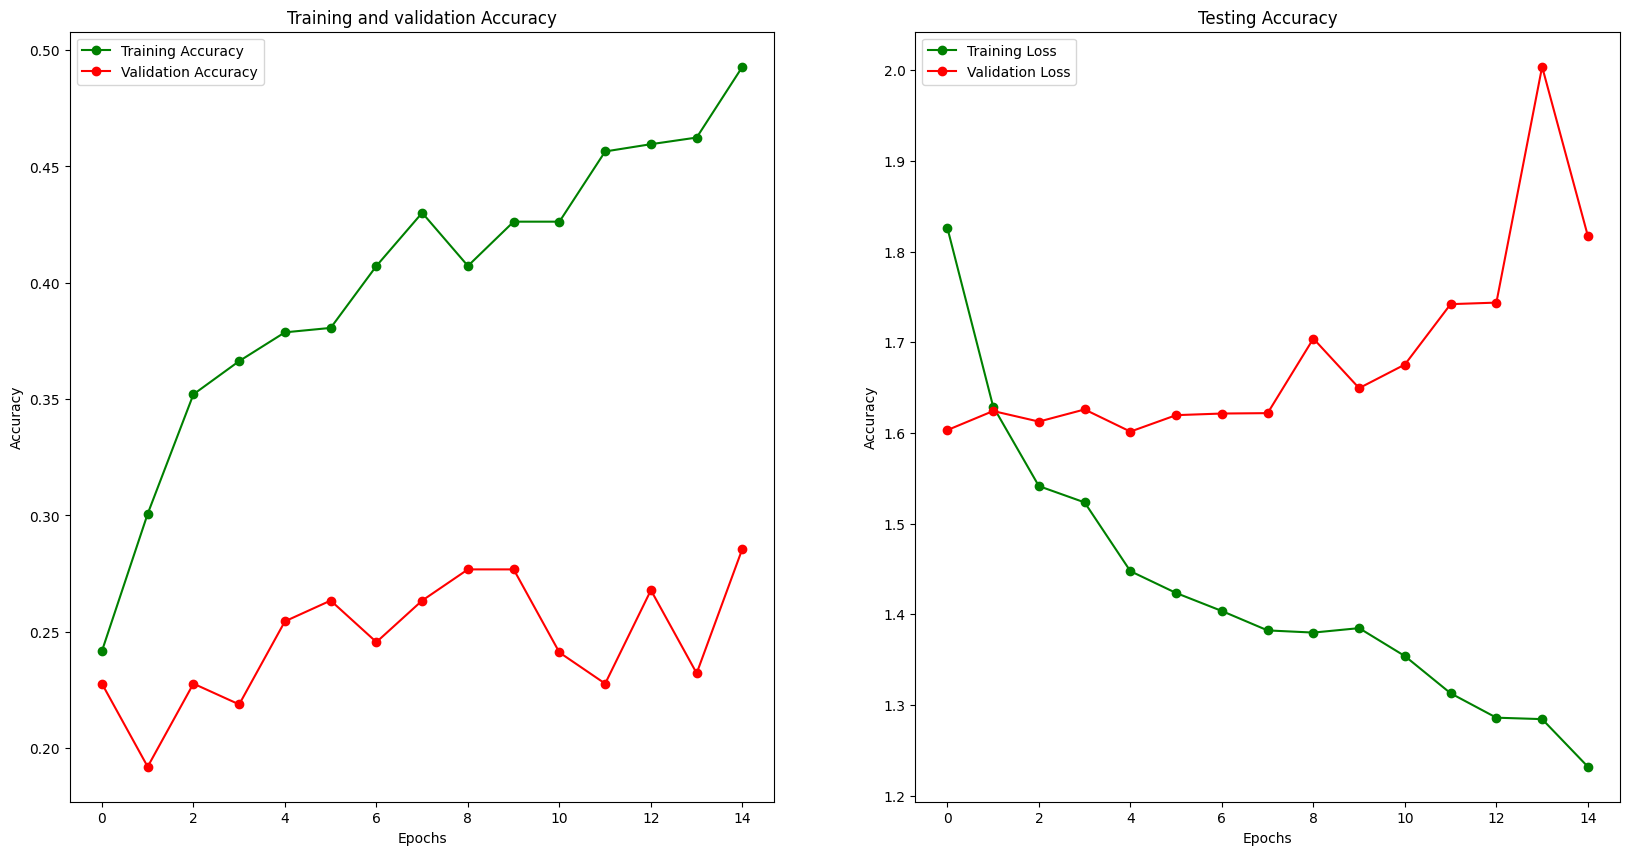

8/8 [==============================] - 4s 115ms/step


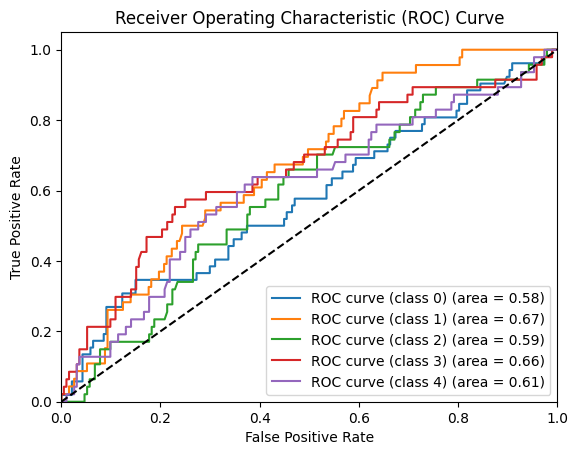

In [33]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 4

In [34]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 108ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.17
Precision: 0.20
Recall: 0.17
F1 Score: 0.15
F2 Score: 0.16
8/8 [==============================] - 1s 111ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.53


# Architecture No 5

In [35]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [36]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8321 - accuracy: 0.2284

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 38s 833ms/step - loss: 1.8321 - accuracy: 0.2284 - val_loss: 1.6197 - val_accuracy: 0.2098
Epoch 2/50
33/33 [==============================] - 24s 719ms/step - loss: 1.6291 - accuracy: 0.2978 - val_loss: 1.6309 - val_accuracy: 0.2143
Epoch 3/50
33/33 [==============================] - 24s 724ms/step - loss: 1.5783 - accuracy: 0.3425 - val_loss: 1.6771 - val_accuracy: 0.2366
Epoch 4/50
33/33 [==============================] - 25s 757ms/step - loss: 1.4901 - accuracy: 0.3625 - val_loss: 1.6137 - val_accuracy: 0.2321
Epoch 5/50
33/33 [==============================] - 26s 772ms/step - loss: 1.4756 - accuracy: 0.3863 - val_loss: 1.6051 - val_accuracy: 0.2723
Epoch 6/50
33/33 [==============================] - 24s 709ms/step - loss: 1.4613 - accuracy: 0.3844 - val_loss: 1.6361 - val_accuracy: 0.2321
Epoch 7/50
33/33 [==============================] - 25s 770ms/step - loss: 1.4119 - accuracy: 0.4091 - val_loss: 1.5684 - val_accuracy: 0.2679
Epoch 8/50

In [37]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 115ms/step - loss: 1.6205 - accuracy: 0.2929
Test accuracy: 0.29


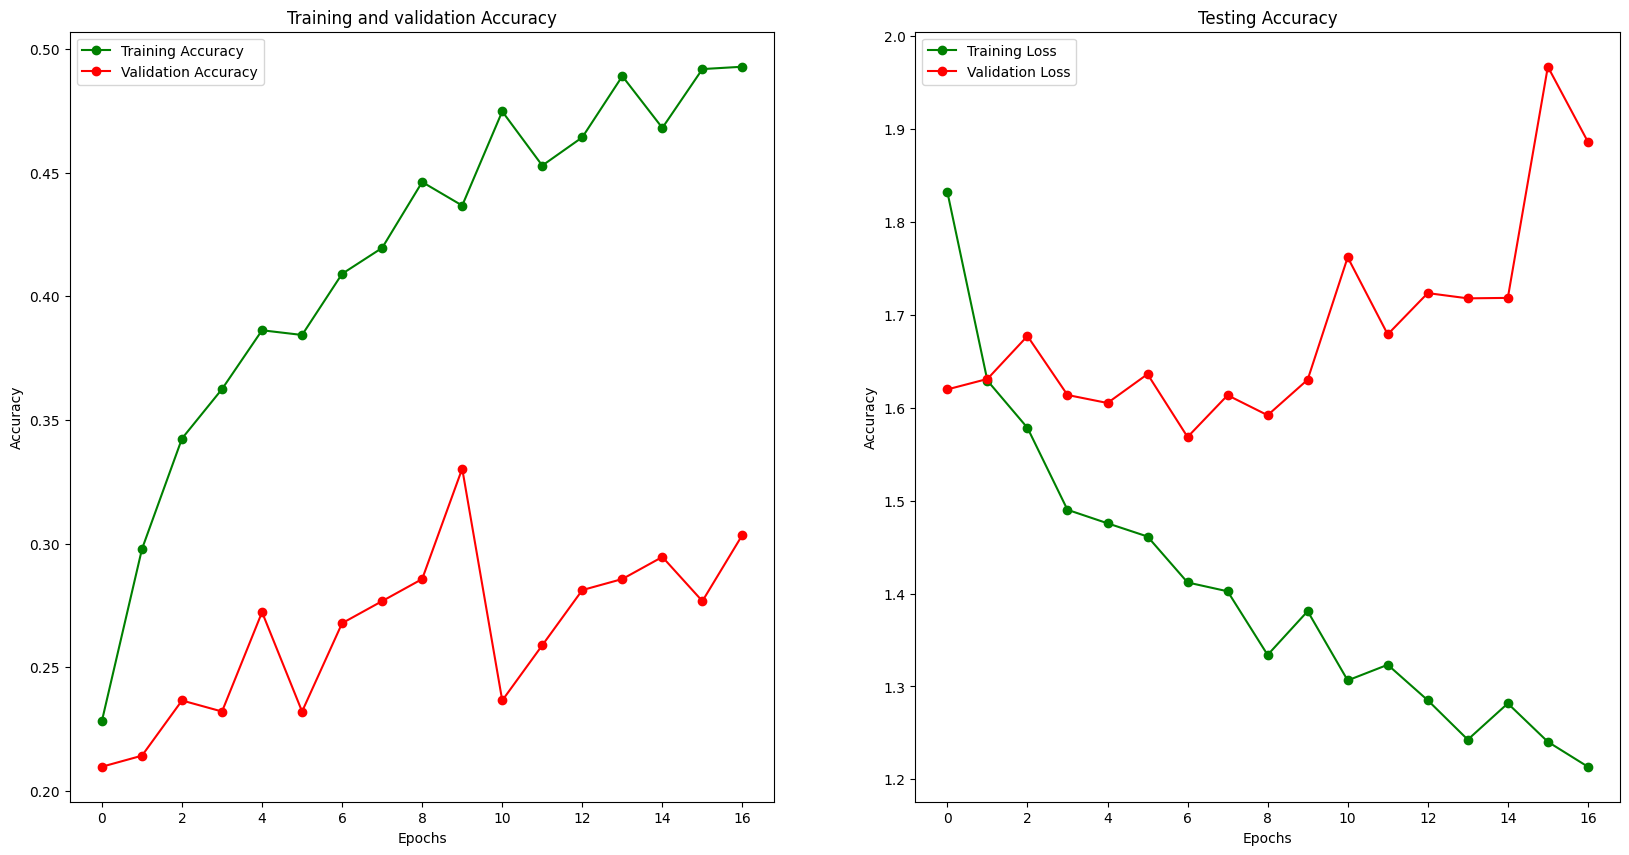

8/8 [==============================] - 5s 122ms/step


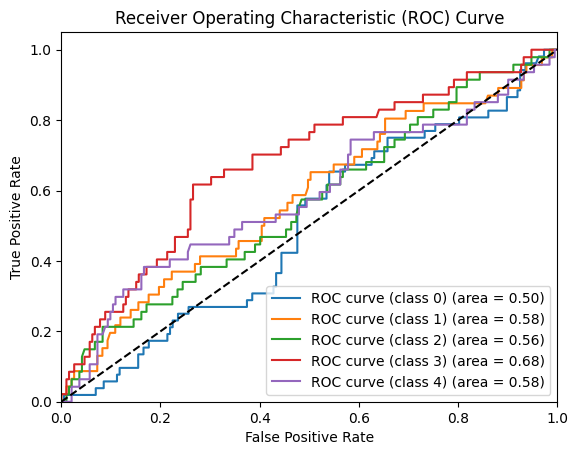

In [38]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 5

In [39]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 108ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.22
Precision: 0.22
Recall: 0.22
F1 Score: 0.21
F2 Score: 0.21
8/8 [==============================] - 1s 115ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.56


# Architecture No 6

In [40]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.7510 - accuracy: 0.2341

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 39s 833ms/step - loss: 1.7510 - accuracy: 0.2341 - val_loss: 1.5953 - val_accuracy: 0.2723
Epoch 2/50
33/33 [==============================] - 25s 761ms/step - loss: 1.6609 - accuracy: 0.2940 - val_loss: 1.5853 - val_accuracy: 0.2589
Epoch 3/50
33/33 [==============================] - 25s 757ms/step - loss: 1.6082 - accuracy: 0.2988 - val_loss: 1.5850 - val_accuracy: 0.2723
Epoch 4/50
33/33 [==============================] - 25s 760ms/step - loss: 1.5679 - accuracy: 0.3054 - val_loss: 1.5728 - val_accuracy: 0.2768
Epoch 5/50
33/33 [==============================] - 25s 766ms/step - loss: 1.5635 - accuracy: 0.3121 - val_loss: 1.5602 - val_accuracy: 0.2679
Epoch 6/50
33/33 [==============================] - 24s 712ms/step - loss: 1.5215 - accuracy: 0.3368 - val_loss: 1.5895 - val_accuracy: 0.2768
Epoch 7/50
33/33 [==============================] - 24s 720ms/step - loss: 1.5428 - accuracy: 0.3475 - val_loss: 1.5640 - val_accuracy: 0.3080
Epoch 8/50

In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 117ms/step - loss: 1.5880 - accuracy: 0.2552
Test accuracy: 0.26


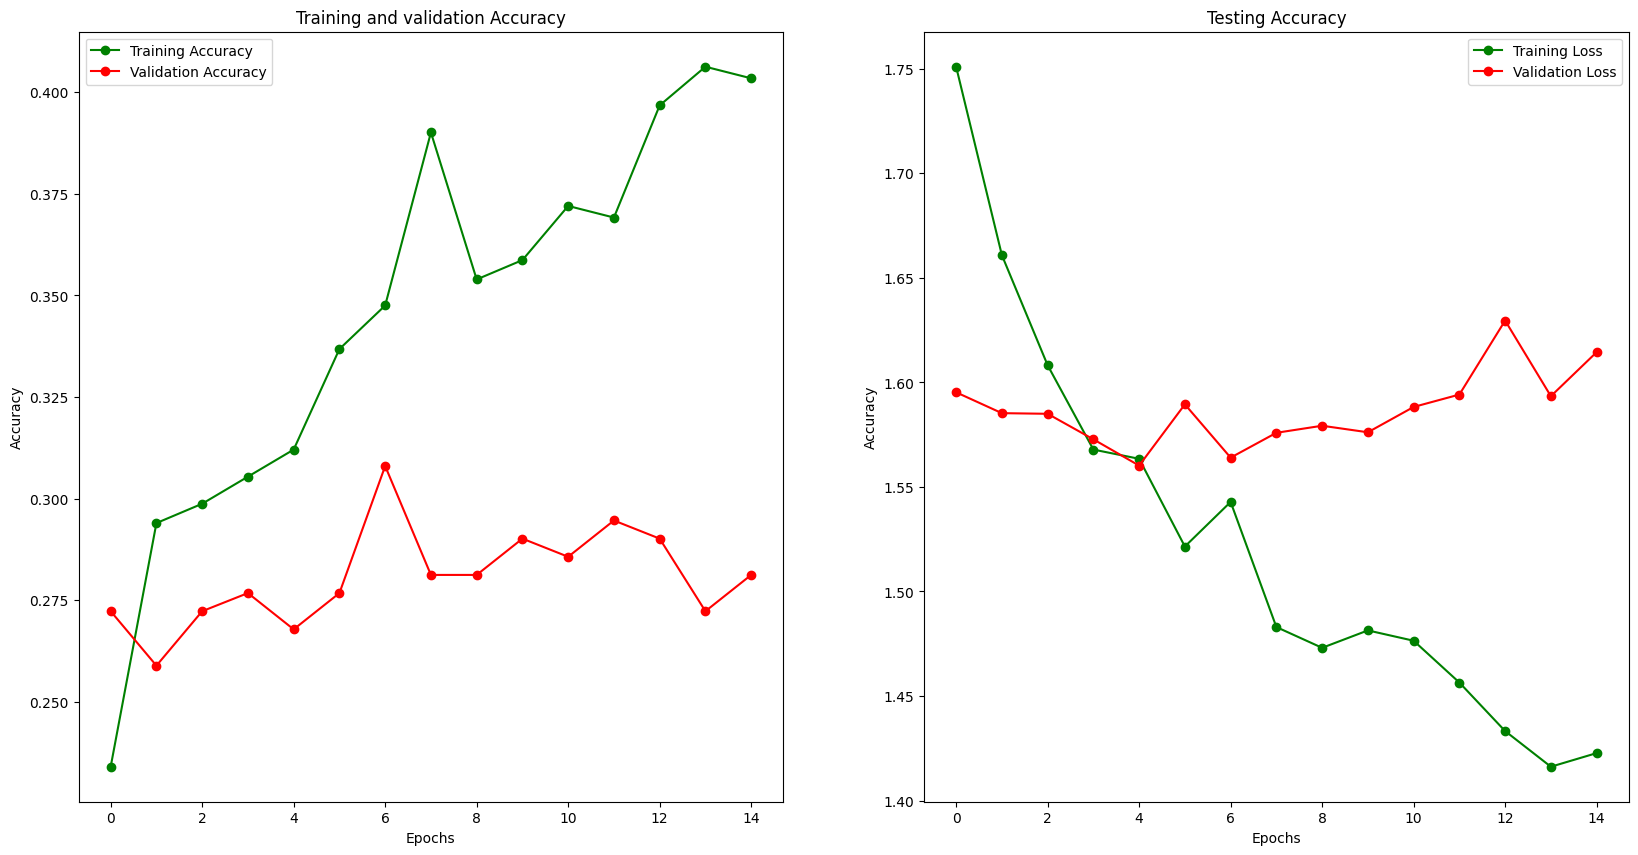

8/8 [==============================] - 4s 103ms/step


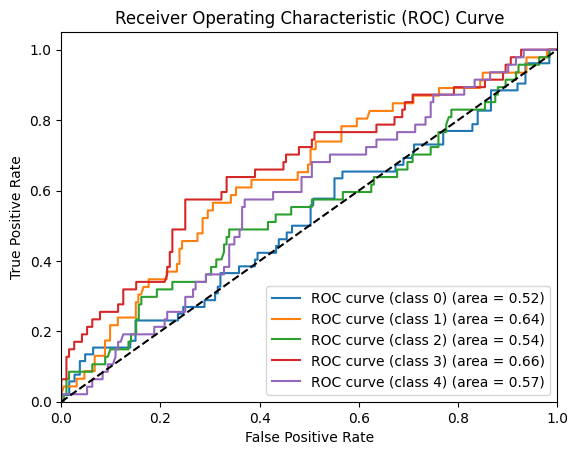

In [43]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 6

In [44]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 104ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.18
Precision: 0.16
Recall: 0.18
F1 Score: 0.15
F2 Score: 0.16
8/8 [==============================] - 1s 108ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.50


# Architecture No 7

In [45]:
# Load the InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [46]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.7892 - accuracy: 0.2350

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 38s 825ms/step - loss: 1.7892 - accuracy: 0.2350 - val_loss: 1.6312 - val_accuracy: 0.2321
Epoch 2/50
33/33 [==============================] - 26s 779ms/step - loss: 1.6641 - accuracy: 0.3016 - val_loss: 1.6246 - val_accuracy: 0.2098
Epoch 3/50
33/33 [==============================] - 25s 767ms/step - loss: 1.6083 - accuracy: 0.2835 - val_loss: 1.6183 - val_accuracy: 0.2098
Epoch 4/50
33/33 [==============================] - 25s 763ms/step - loss: 1.5617 - accuracy: 0.3140 - val_loss: 1.5930 - val_accuracy: 0.2321
Epoch 5/50
33/33 [==============================] - 24s 714ms/step - loss: 1.5024 - accuracy: 0.3644 - val_loss: 1.6177 - val_accuracy: 0.2009
Epoch 6/50
33/33 [==============================] - 25s 766ms/step - loss: 1.5289 - accuracy: 0.3473 - val_loss: 1.5779 - val_accuracy: 0.2679
Epoch 7/50
33/33 [==============================] - 25s 772ms/step - loss: 1.4801 - accuracy: 0.3654 - val_loss: 1.5712 - val_accuracy: 0.2411
Epoch 8/50

In [47]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 101ms/step - loss: 1.5888 - accuracy: 0.2678
Test accuracy: 0.27


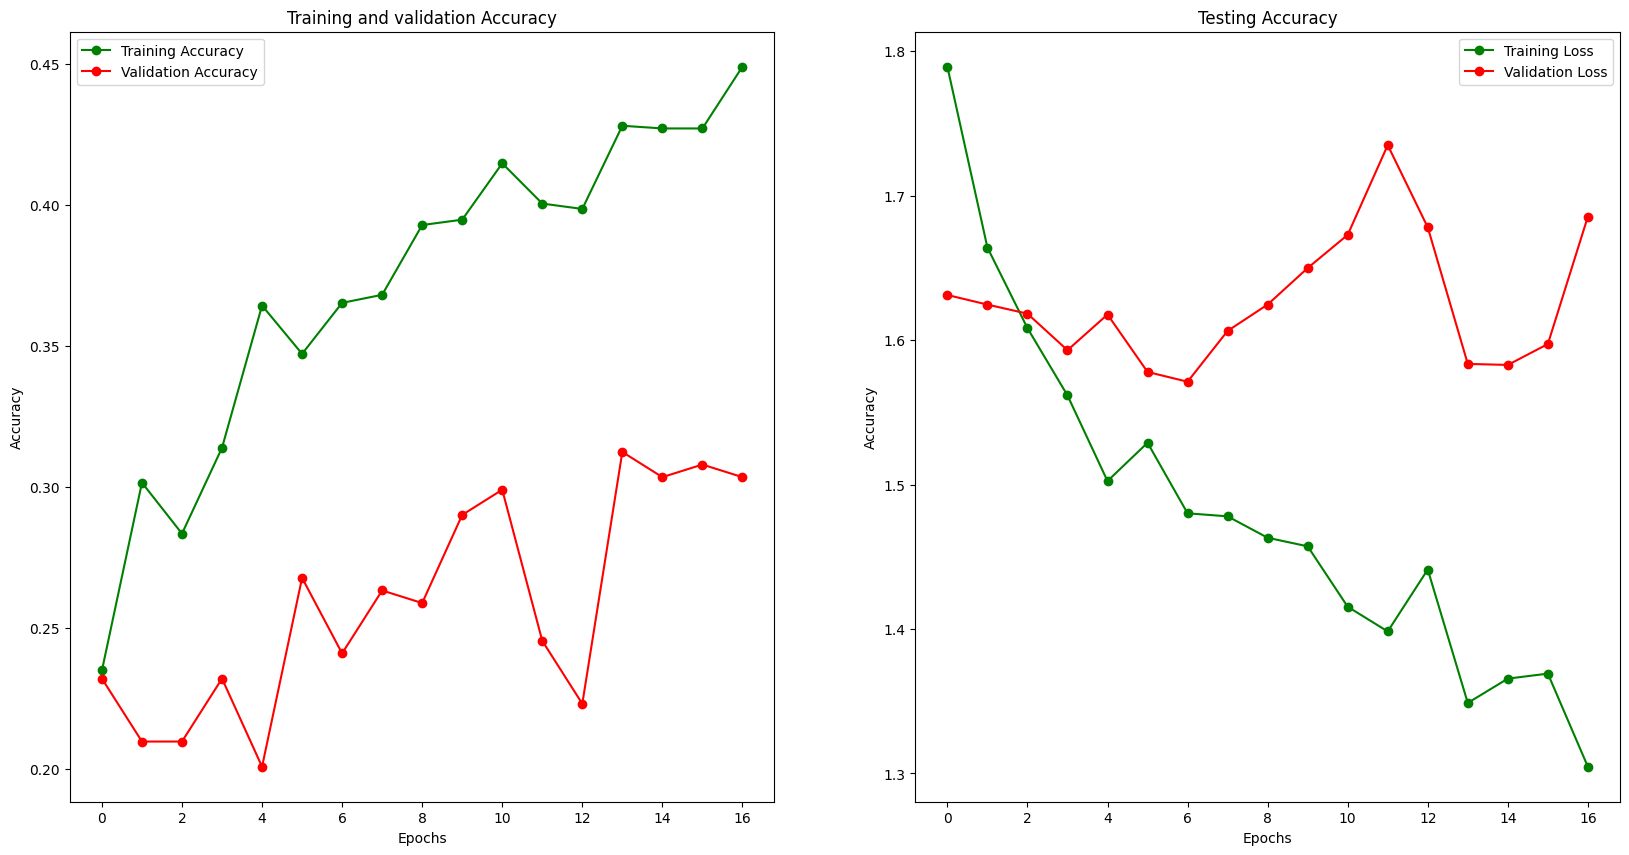

8/8 [==============================] - 4s 113ms/step


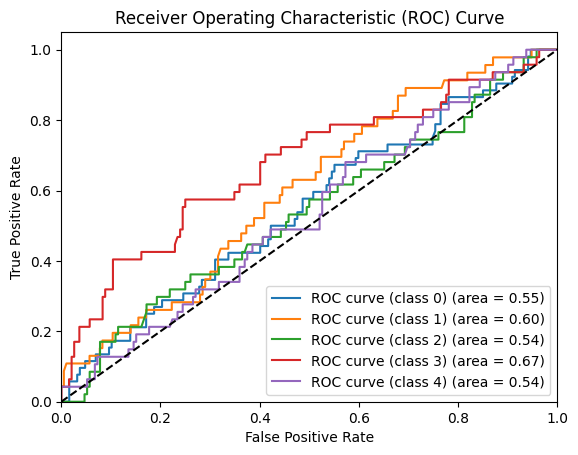

In [48]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 7

In [49]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 111ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.22
Precision: 0.22
Recall: 0.22
F1 Score: 0.19
F2 Score: 0.20
8/8 [==============================] - 1s 106ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.50
